## Create trajectory

In [2]:
import json
from ase import Atoms, io
from ase.build import molecule
import os
import sys
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ase.io import read, Trajectory, write
from ase.visualize.plot import plot_atoms
from ase.visualize import view

from functools import reduce, partial
import numpy as np
# Use the notebook backend for interactive plots
from qtm import chem_config

In [3]:
# ⚠️⚠️ config cell ⚠️⚠️
chem_conf_path = os.path.join("qtm", "chem_config.yaml")
ml_conf_path = os.path.join("qtm", "ml_config.yaml")

def _load_json(*dirs):
    json_file = os.path.join(*dirs)
    with open(json_file) as f:
        js = json.load(f)
    return js

def _load_json_linewise(*dirs):
    json_file = os.path.join(*dirs)
    with open(json_file) as f:
        js = [json.loads(line) for line in f]
    return js

try:
    # for yaml based config 
    from omegaconf import OmegaConf
    try:
        OmegaConf.register_new_resolver("concat", lambda x, y: x + y)
        OmegaConf.register_new_resolver("divide", lambda x, y: x / y)
        OmegaConf.register_new_resolver("sum", lambda *numbers: sum(numbers))
        OmegaConf.register_new_resolver("load_json", _load_json)
        OmegaConf.register_new_resolver("last_element", lambda x: x[-1])
        chem_conf = OmegaConf.load(chem_conf_path)
        chem_conf._set_flag("allow_objects", True)
        ml_conf = OmegaConf.load(ml_conf_path)
        OmegaConf.resolve(chem_conf)
        OmegaConf.resolve(ml_conf)
    except ValueError:  # resolver registered
        pass

    step_config = chem_conf["steps"][chem_conf.get("step_to_run", None)]
    
    optimizable_molecules = step_config["react"]["symbols"]
    optimizable_coords = step_config["react"]["coords"]
    coordinate_file_name='coords_bo3.txt'
    energies_file_name = 'energies_bo3.txt'
except ImportError:
    coordinate_file_name='coords.txt'
    
    # molecules = [chem_config.NH2, chem_config._N1_step1, chem_config._N2_step1, chem_config._N3_step1]
    molecules = chem_config.step2


# molecules = [chem_config.NH2, chem_config._N1_step1, chem_config._N2_step1, chem_config._N3_step1]
molecules = chem_config.step2
step = 'step2' # folder name, remember make sure it matches with the omegaconf
traj_file_name=os.path.join("artifact", step, coordinate_file_name.replace('.txt', '.traj'))


In [4]:
# to be optimized coordinates
molecular_positions = []
with open(os.path.join("artifact", step, coordinate_file_name)) as f:
    for l in f:
        molecular_positions.append(json.loads(l.strip()))

In [5]:
# Filter trajectory (optional)
idx_molecular_positions = [(idx, i) for idx, i in enumerate(molecular_positions) if (-0.15 < i[0] < 3) and (0.9 < i[1]< 4.57) 
                 and (-0.15 < i[3] < 3.15) and (0.9-0.15 < i[4] < 4.57+0.15)]


In [6]:
idx = [_[0] for _ in idx_molecular_positions]
molecular_positions = [_[1] for _ in idx_molecular_positions]

In [7]:
idx

[3, 9, 12, 51]

In [83]:
molecular_positions

[[-0.12929729591679995,
  3.0884120645008997,
  2.5875072441995,
  0.8999248454789999,
  3.8737031192397,
  2.0572795355693],
 [1.9468642455029002,
  1.5738390999795997,
  2.7617169022560004,
  1.4572657535055,
  3.1431269318132005,
  2.5535552985966006],
 [0.02154712826759997,
  2.5530692801787,
  2.0896048964932996,
  2.5671884889529,
  4.2419244741081,
  2.2054421175271],
 [1.3456069256891,
  2.0209962914605,
  2.5256638119784,
  1.1415902450295998,
  4.359460991862,
  2.1558803483411]]

In [84]:
molecular_positions[0], molecular_positions[-1] = molecular_positions[-1], molecular_positions[0]  

In [85]:
molecular_positions

[[1.3456069256891,
  2.0209962914605,
  2.5256638119784,
  1.1415902450295998,
  4.359460991862,
  2.1558803483411],
 [1.9468642455029002,
  1.5738390999795997,
  2.7617169022560004,
  1.4572657535055,
  3.1431269318132005,
  2.5535552985966006],
 [0.02154712826759997,
  2.5530692801787,
  2.0896048964932996,
  2.5671884889529,
  4.2419244741081,
  2.2054421175271],
 [-0.12929729591679995,
  3.0884120645008997,
  2.5875072441995,
  0.8999248454789999,
  3.8737031192397,
  2.0572795355693]]

In [86]:
if "omegaconf" in sys.modules:
    molecular_positions = [[*np.reshape(step_config["fixed"]["coords"], (-1,3)),
                        *np.reshape(molecular_position, (-1, 3))]
                       for molecular_position in molecular_positions] 
    symbols = step_config["fixed"]["symbols"] + step_config["react"]["symbols"]

else:
    molecular_positions = [[*np.reshape(chem_config.Fe['coords'],(-1, 3)),
                        *np.reshape(molecular_position, (-1, 3))]
                       for molecular_position in molecular_positions] 
    symbols = chem_config.Fe['symbols'] +  reduce(lambda x, y: x+y, [x['symbols'] for x in molecules])


Create traj file

In [87]:
# Example atomic symbols

# Create a Trajectory object
traj = Trajectory(traj_file_name, 'w')

# Loop through each frame and create an Atoms object
for frame in molecular_positions:    
    atoms = Atoms(symbols=symbols, positions=frame)
    traj.write(atoms, rotation="22z")

# Close the trajectory file
traj.close()

## Animate trajectory

In [91]:
!ase gui {traj_file_name}

## Create GIF

In [89]:
traj = Trajectory(traj_file_name)

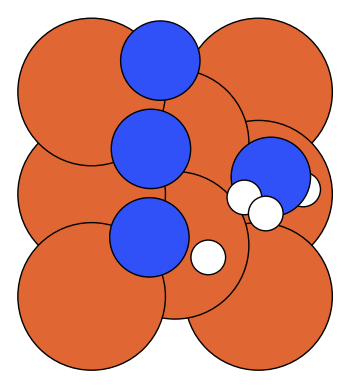

In [92]:
io.write(traj_file_name.replace(".traj", ".gif"), traj, interval=1000, rotation="0x,0y,180z")

## Create Fe bulk

In [6]:
from ase.build import bulk, surface
from ase.visualize import view

# Create bulk BCC iron
bulk_fe = bulk('Fe', 'bcc', a=2.856)  # lattice constant for BCC iron

# Create the (211) surface with 3 layers and 10 Å vacuum
fe_211_surface = surface(bulk_fe, (2, 1, 1), layers=3, vacuum=10.0)

# Center the surface slab in the cell
fe_211_surface.center(axis=2)

# View the structure
view(fe_211_surface, viewer='ngl')

In [7]:
#coords = [-4.3857516, 2.42202895, -4.41477892, -3.88343244,  2.62167029, -4.71856799, -4.65836314,  2.78615741, -3.9935248]

fe_top = [1.0, 0.0, 0.50]
fe_bottom = [0.69, 0.14, 0.36]
fe_climbing = [0.63, 0.58, 0.44]
fe_bridge = [0.7, 1.0, 0.44]
fe_trough = [0.59, 0.5, 0.31]


fe_lattice = Atoms(
 #   f"FeFeFeFeFeNHH",
    f"FeFeFeFeFeFeFeFe",
       [[ 2.98605559e+00,  9.14289068e-01,  1.05573008e+00],
       [ 2.98605559e+00,  2.74286720e+00,  1.05573008e+00],
       [ 2.98605559e+00,  4.57144534e+00,  1.05573008e+00],
       #[ 1.49302780e+00, -1.43551837e-16,  5.27865040e-01],
       [ 1.49302780e+00,  1.82857814e+00,  5.27865040e-01],
       [ 1.49302780e+00,  3.65715627e+00,  5.27865040e-01],
       [ 1.25981645e-16,  9.14289068e-01,  0.00000000e+00],
       [ 1.25981645e-16,  2.74286720e+00,  0.00000000e+00],
       [ 1.25981645e-16,  4.57144534e+00,  0.00000000e+00] ]
    
)

view(fe_lattice, viewer='ngl')

In [8]:
from ase import Atoms
from ase.build import fcc211, bulk
from ase.io import read, write

a = 2.586  # vertex constant

slab = fcc211('Fe', (3, 3, 1), a=a)
view(slab, viewer='ngl')

In [9]:
slab.get_positions()

array([[ 2.98605559e+00,  9.14289068e-01,  1.05573008e+00],
       [ 2.98605559e+00,  2.74286720e+00,  1.05573008e+00],
       [ 2.98605559e+00,  4.57144534e+00,  1.05573008e+00],
       [ 1.49302780e+00, -1.43551837e-16,  5.27865040e-01],
       [ 1.49302780e+00,  1.82857814e+00,  5.27865040e-01],
       [ 1.49302780e+00,  3.65715627e+00,  5.27865040e-01],
       [ 1.25981645e-16,  9.14289068e-01,  0.00000000e+00],
       [ 1.25981645e-16,  2.74286720e+00,  0.00000000e+00],
       [ 1.25981645e-16,  4.57144534e+00,  0.00000000e+00]])

In [2]:
temp_coords = "0.3971556959170808, 2.5807740683066935, 1.59450983792887, 0.9067000404676966, 2.920382841733446, 1.6919749185888644, -0.16091996606189735, 2.850757130003617, 1.599233385693058, 1.8749878093307049, 0.6605548612821897, 2.2304022467832056, 1.9526558469941664, 1.9664420965973384, 2.3020270963182066, 1.96061627556519, 3.2873361443705207, 2.3298917415531757"

temp_coords = list(map(float, temp_coords[1:-1].split(',')))

In [3]:
fe_lattice = Atoms(
    "".join(chem_config.Fe['symbols']+chem_config.NH2['symbols']+['N','N','N']),
    [*np.reshape(chem_config.Fe['coords'],(-1, 3)),
     *np.reshape(temp_coords,(-1, 3)),   
     #*np.reshape(chem_config.NH2['coords'], (-1, 3))
    ]
)

view(fe_lattice, viewer='ngl')

### step 2

In [9]:
np.hstack([x['coords'] for x in chem_config.step2]).reshape(-1,3)

array([[0.97361725, 0.99776673, 1.99935516],
       [1.99054639, 4.03343409, 1.99108501]])

In [ ]:
[-0.3, 0.99776673, 1.99935516],
[2.99054639, 4.03343409, 1.99108501]

In [18]:
fe_lattice = Atoms(
    np.hstack(chem_config.Fe['symbols']+ [x['symbols'] for x in chem_config.step2_fix] +  [x['symbols'] for x in chem_config.step2]),
    [*np.reshape(chem_config.Fe['coords'],(-1, 3)),
     *np.hstack([x['coords'] for x in chem_config.step2_fix]).reshape(-1,3),
     [-0.3, 0.99776673, 1.99935516],
     [2.99054639, 4.03343409, 1.99108501]
    ]
)

view(fe_lattice, viewer='ngl')

# Energy chart

In [81]:
energies = []

with open(os.path.join("artifact", "step2", energies_file_name)) as f:
    try:
        for line in f:
            energies.append(float(line.strip()))
    except ValueError:
        f.seek(0)
        energies = json.load(f)

        
energies = np.array(energies)

In [93]:
energies = energies[[51, 9, 12, 3]]

In [95]:
energies

array([-10130.91527795, -10122.82763321, -10118.43348834, -10131.98372252])

In [103]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 320  
plt.ioff()
fig, ax = plt.subplots()

artists = []
for i in tqdm(range(len(energies))):
    print(energies[:i+1])
    container = ax.plot(range(i+1), energies[:i+1])
    artists.append(container)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=1000)
ani.save("god.gif",  writer="pillow")

  0%|          | 0/4 [00:00<?, ?it/s]

[-10130.91527795]
[-10130.91527795 -10122.82763321]
[-10130.91527795 -10122.82763321 -10118.43348834]
[-10130.91527795 -10122.82763321 -10118.43348834 -10131.98372252]


In [25]:
fe_lattice = Atoms(
    np.hstack(chem_config.Fe['symbols']+ [x['symbols'] for x in chem_config.step2_fix] +  [x['symbols'] for x in chem_config.step2]),
    [*np.reshape(chem_config.Fe['coords'],(-1, 3)),
     *np.hstack([x['coords'] for x in chem_config.step2_fix]).reshape(-1,3),
    [-0.8631129368032,
 4.1860349535627,
 2.6888624522835],
 [3.0991096767490003,
 2.8267188370752,
 2.3468265365809002] 
    ]
)

view(fe_lattice, viewer='ngl')